Model trained on contaxts being normalised code. 

In [1]:
from transformers import (
    BartTokenizerFast,
    DataCollatorForSeq2Seq,
    keras_callbacks,
    TFAutoModelForSeq2SeqLM,
)
import tensorflow as tf
from datasets import Dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
from huggingface_hub import notebook_login
from datasets import concatenate_datasets
from question_answering.constants import constants
from question_answering.utils import core_qa_utils, generative_qa_utils
from question_answering.paths import generative_qa_paths
from question_answering.keras_callbacks.time_measure_callback import TimeMeasureCallback

In [2]:
df_train, df_val, df_test = core_qa_utils.load_datasets_from_csv(
    generative_qa_paths.python_dataset_dir
)

df_train = pd.concat([df_train, df_val], ignore_index=True)

train_dataset, test_dataset = core_qa_utils.convert_dataframes_to_datasets(
    [df_train, df_test]
)

code_type = 'original_code'
code_type = 'code'

In [3]:
model_checkpoint = "facebook/bart-base"
tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-base")

In [4]:
def tokenize_sample(sample, max_tokens=None, padding=False):
    question = sample["questions"].strip()
    context = sample[code_type].strip()

    return tokenizer(question, context, max_length=max_tokens, padding=padding)

tokenized_train_dataset = train_dataset.map(tokenize_sample)
tokenized_test_dataset = test_dataset.map(tokenize_sample)

print(
    "Max number of tokens in tokenized train dataset: ",
    len(max(tokenized_train_dataset["input_ids"], key=len)),
)
print(
    "Max number of tokens in tokenized test dataset: ",
    len(max(tokenized_test_dataset["input_ids"], key=len)),
)

Map:   0%|          | 0/63080 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
max_length = 256


def filter_samples_below_number_of_tokens(dataset, max_tokens: int):
    indices_to_remove = []

    # Find indices of samples where number of tokens exceeds max number of tokens
    for index, sample in enumerate(dataset):
        tokenized_sample = tokenize_sample(sample)
        if len(tokenized_sample["input_ids"]) > max_tokens:
            indices_to_remove.append(index)

    # Keep only samples with number of tokens less or equal than max number of tokens
    dataset_indices = range(len(dataset))
    filtered_dataset = dataset.select(
        index for index in dataset_indices if index not in set(indices_to_remove)
    )

    return filtered_dataset


filtered_train_dataset = filter_samples_below_number_of_tokens(
    train_dataset, max_tokens=max_length
)
filtered_test_dataset = filter_samples_below_number_of_tokens(
    test_dataset, max_tokens=max_length
)

Parameter 'indices'=<generator object filter_samples_below_number_of_tokens.<locals>.<genexpr> at 0x000001C5462C8CF0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [ ]:
print(
    "Number of samples in tokenized train dataset before filtering: ",
    len(train_dataset),
)
print(
    "Number of samples in tokenized test dataset before filtering: ", len(test_dataset)
)

print("\n---------------\n")

print(
    "Number of samples in tokenized train dataset after filtering: ",
    len(filtered_train_dataset),
)
print(
    "Number of samples in tokenized test dataset after filtering: ",
    len(filtered_test_dataset),
)

Number of samples in tokenized train dataset before filtering:  63080
Number of samples in tokenized test dataset before filtering:  3500

---------------

Number of samples in tokenized train dataset after filtering:  61758
Number of samples in tokenized test dataset after filtering:  3430


In [ ]:
def preprocess_dataset(dataset):
    questions = [q.strip() for q in dataset["questions"]]
    contexts = [c.strip() for c in dataset[code_type]]
    answers = [c.strip() for c in dataset["answers"]]

    inputs = tokenizer(
        questions,
        contexts,
        text_target=answers,
        max_length=max_length,
        truncation=True
    )

    return inputs

In [ ]:
tokenized_train_dataset = filtered_train_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_train_dataset.column_names,
)
tokenized_test_dataset = filtered_test_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_test_dataset.column_names,
)

Map:   0%|          | 0/61758 [00:00<?, ? examples/s]

Map:   0%|          | 0/3430 [00:00<?, ? examples/s]

In [ ]:
# Model parameters
training_number = 1

model_name = "python-bart-normalised"
full_model_name = f"{model_name}-{training_number}"

# Checkpoints
checkpoint_filename_template = constants.checkpoint_filename_template
checkpoints_path = (
    generative_qa_paths.training_checkpoints_dir
    / full_model_name
    / checkpoint_filename_template
)

# Hub
hub_path = generative_qa_paths.hub_models_location / full_model_name

# Saved models
saved_models_path = generative_qa_paths.saved_models_dir / full_model_name

# Evaluation
model_evaluation_dir = generative_qa_paths.model_evaluation_dir / full_model_name

# Hyperparameters
batch_size = 8
train_epochs = 3
initial_learning_rate = 2e-5 
end_learning_rate = 0.0

In [ ]:
# Load model for fine-tuning
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBartForConditionalGeneration: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
- This IS expected if you are initializing TFBartForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBartForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [ ]:
# Dataset preparation
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

tf_train_dataset = core_qa_utils.prepare_tf_dataset(
    model=model,
    hf_dataset=tokenized_train_dataset,
    collator=data_collator,
    batch_size=batch_size,
    shuffle=True
)

tf_test_dataset = core_qa_utils.prepare_tf_dataset(
    model=model,
    hf_dataset=tokenized_test_dataset,
    collator=data_collator,
    batch_size=batch_size,
)

NameError: name 'tokenized_train_dataset' is not defined

In [ ]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, verbose=1, save_weights_only=True
)
# push_to_hub = keras_callbacks.PushToHubCallback(
#     output_dir=full_model_name, tokenizer=tokenizer
# )

time_measure_cb = TimeMeasureCallback()

callbacks = [
    checkpoint_cb,
    # push_to_hub,
    time_measure_cb
]

In [ ]:
# Compile
num_train_steps = len(tf_train_dataset) * train_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate, 
    end_learning_rate=end_learning_rate, 
    decay_steps=num_train_steps
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Compile
model.compile(optimizer=optimizer)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070, compute capability 8.9


In [ ]:
model.summary()

Model: "tf_bart_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
 final_logits_bias (BiasLaye  multiple                 50265     
 r)                                                              
                                                                 
Total params: 139,470,681
Trainable params: 139,420,416
Non-trainable params: 50,265
_________________________________________________________________


In [ ]:
# Fit the model on the new data
history = model.fit(
    tf_train_dataset,
    epochs=train_epochs,
    callbacks=callbacks,
)

Epoch 1/3
7719/7719 [==============================] - ETA: 0s - loss: 2.7848
Epoch 1: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\python-bart-uncased-1\cp-01.ckpt
7719/7719 [==============================] - 982s 124ms/step - loss: 2.7848
Epoch 2/3
7719/7719 [==============================] - ETA: 0s - loss: 2.0790
Epoch 2: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\python-bart-uncased-1\cp-02.ckpt
7719/7719 [==============================] - 953s 123ms/step - loss: 2.0790
Epoch 3/3
7719/7719 [==============================] - ETA: 0s - loss: 1.6685
Epoch 3: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\python-bart-uncased-1\cp-03.ckpt
7719/7719 [==============================] - 951s 123ms/step - loss: 1.6685


In [16]:
# Get best version of the model
best_model, best_epoch = core_qa_utils.get_best_model_from_checkpoints(
    model, history, model_name=full_model_name, metric="loss", remove_checkpoints=True, model_type="generative"
)

In [17]:
# Save best model's weights
generative_qa_utils.save_model(best_model, model_name=full_model_name)

In [15]:
loaded_weights_model = generative_qa_utils.load_weights_into_model(
    model=model, 
    model_name=full_model_name
)

In [19]:
# Get predictions from the best model
loaded_model_evaluation = loaded_weights_model.evaluate(tf_test_dataset)

429/429 [==============================] - 29s 53ms/step - loss: 2.6181


In [20]:
parts_number = 100

test_dataset_pandas = tokenized_test_dataset.to_pandas()
test_dataset_array = np.array_split(test_dataset_pandas, parts_number)

test_datasets_list = []

for row in tqdm(test_dataset_array):
    test_datasets_list.append(core_qa_utils.prepare_tf_dataset(
        model=model,
        hf_dataset=Dataset.from_pandas(row),
        collator=data_collator,
        batch_size=batch_size,
))

c:\Users\Artur\.conda\envs\question_answering\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


In [21]:
questions_and_answers_df = pd.DataFrame()
index_to_start_from = 0
predictions_list = []
labels_list = []
question_contexts_list = []

i = 0
for dataset in tqdm(test_datasets_list):
    if i < index_to_start_from:
        i = i + 1
        continue
    for batch, labels in tqdm(dataset):
        predictions = generative_qa_utils.generate_predictions(model, batch, max_length)
        decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        labels = labels
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_predictions = [prediction.strip() for prediction in decoded_predictions]
        decoded_labels = [label.strip() for label in decoded_labels]
        predictions_list.extend(decoded_predictions)
        labels_list.extend(decoded_labels)
        question_contexts_list.extend(tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True))

        data = {
            'question_contexts': tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True),
            'labels': decoded_labels,
            'predictions': decoded_predictions
        }
        questions_and_answers_df = pd.concat([questions_and_answers_df, pd.DataFrame(data)], ignore_index=True)
    i = i + 1

100%|██████████| 100/100 [47:49<00:00, 28.69s/it]


In [36]:
dataset_dataframe_with_predictions = generative_qa_utils.split_questions_and_contexts_into_two_columns(dataframe=questions_and_answers_df)
dataset_dataframe_with_predictions

,questions,contexts,labels,predictions
0,How does the code add a user in the given buck...,def add_bucket_default_owner bucket_name user_...,as an owner,by name
1,Does the code add a user in the given buckets ...,def add_bucket_default_owner bucket_name user_...,Yes,Yes
2,Where does the code add a user as an owner?,def add_bucket_default_owner bucket_name user_...,in the given buckets default object access con...,in a bucket
3,Does the code create a simple sdist tarball at...,def make_trivial_sdist dist_path setup_py setu...,Yes,Yes
4,How does the code create a simple sdist tarball?,def make_trivial_sdist dist_path setup_py setu...,at dist_path,using the given setup
...,...,...,...,...
3425,What does the code add to a virtual service?,def add_server protocol None service_address N...,a real server,a server
3426,What does the code get?,def get_codon_alphabet alphabet gap '-' stop '...,alignment alphabet for codon alignment,the codon alphabet
3427,What does the code get?,def get_ancestors x collection None if collect...,ancestor random variables of input,the list of possible candidates for the given ...
3428,What does the code perform?,def lookupNameservers name timeout None return...,an ns record lookup,a record lookup


In [25]:
bleu_result, rogue_result, meteor_result= generative_qa_utils.get_metrics(dataset_dataframe_with_predictions)
print(
    "BLEU:\n",
    bleu_result,
    "\nROGUE:\n",
    rogue_result,
    "\nMETEOR:\n",
    meteor_result
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BLEU:
 {'bleu': 0.08257298141743828, 'precisions': [0.4183647369767244, 0.1635136763465478, 0.09492726594554271, 0.06425948592411261], 'brevity_penalty': 0.5777349249977212, 'length_ratio': 0.6457278132569918, 'translation_length': 11729, 'reference_length': 18164} 
ROGUE:
 {'rouge1': 0.34269150701559653, 'rouge2': 0.1052504051751496, 'rougeL': 0.33325207286795455, 'rougeLsum': 0.3325781703895115} 
METEOR:
 {'meteor': 0.2233127058663237} 
VERTSCORE:
 {'precision': [0.8356630206108093, 1.000000238418579, 0.8723040819168091, 1.000000238418579, 0.852370023727417, 0.9296540021896362, 0.8875028491020203, 0.9992695450782776, 0.8870806097984314, 1.000000238418579, 0.9390777349472046, 1.000000238418579, 1.0, 0.9097198843955994, 0.9749985337257385, 1.000000238418579, 1.000000238418579, 0.8469901084899902, 0.9992695450782776, 0.8454920649528503, 0.9012614488601685, 1.000000238418579, 0.8713245391845703, 0.9992695450782776, 1.000000238418579, 0.884512722492218, 1.000000238418579, 0.88455307483673

In [5]:
closed_questions_dictionary = generative_qa_utils.get_closed_questions_split_according_to_answer_correctness(dataframe=dataset_dataframe_with_predictions)

number_of_closed_questions = len(closed_questions_dictionary['closed_all'])
number_of_correct_answers = len(closed_questions_dictionary['closed_correct_answer'])
number_of_wrong_answers = len(closed_questions_dictionary['closed_wrong_answer'])

number_of_long_answers_for_closed_questions = len(closed_questions_dictionary['closed_long_answer'])

print("Correct answers: ", number_of_correct_answers)
print("Wrong answers: ", number_of_wrong_answers)
print("Long answers for closed questions: ", number_of_long_answers_for_closed_questions)
print("Wrong answers without the long ones: ", number_of_wrong_answers - number_of_long_answers_for_closed_questions)

Correct answers:  116
Wrong answers:  35
Long answers for closed questions:  0
Wrong answers without the long ones:  35


In [26]:
# Save all relevant training and evaluation metrics to a json file.
evaluation_data = {
    "training": {
        "metrics": history.history,
        "attempted_epochs": train_epochs,
        "best_epoch": best_epoch,
        "training_time": time_measure_cb.total_training_time(),
        "gpu": core_qa_utils.get_gpu_name(),
    },
    "test_set": {
        "loss": loaded_model_evaluation,
        "bleu": bleu_result,
        "rogue": rogue_result,
        "meteor": meteor_result,
        "closed_questions": {
            "closed_questions_number": number_of_closed_questions,
            "correct_answers_number": number_of_correct_answers,
            "wrong_answers_number": number_of_wrong_answers,
            "long_answers_for_closed_questions_number": number_of_long_answers_for_closed_questions,
        }
    },
}

core_qa_utils.save_dict_as_json(
    evaluation_data, dir_path=model_evaluation_dir, filename="evaluation_data.json"
)

In [18]:
dataset_dataframe_with_predictions = generative_qa_utils.calculate_bleus_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions = generative_qa_utils.calculate_rouges_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions = generative_qa_utils.calculate_meteor_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions

3430it [01:08, 50.43it/s]
3430it [30:39,  1.86it/s]
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
3430it [00:36, 93.71it/s] 


,index,questions,contexts,labels,predictions,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
0,0,How does the code add a user in the given buck...,def add_bucket_default_owner bucket_name user_...,as an owner,by name,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,1,Does the code add a user in the given buckets ...,def add_bucket_default_owner bucket_name user_...,Yes,Yes,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.500000
2,2,Where does the code add a user as an owner?,def add_bucket_default_owner bucket_name user_...,in the given buckets default object access con...,in a bucket,0.0,0.333333,0.0,0.166667,0.0,0.166667,0.119048
3,3,Does the code create a simple sdist tarball at...,def make_trivial_sdist dist_path setup_py setu...,Yes,Yes,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.500000
4,4,How does the code create a simple sdist tarball?,def make_trivial_sdist dist_path setup_py setu...,at dist_path,using the given setup,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
3425,3425,What does the code add to a virtual service?,def add_server protocol None service_address N...,a real server,a server,0.0,1.000000,0.0,0.800000,0.0,0.800000,0.344828
3426,3426,What does the code get?,def get_codon_alphabet alphabet gap '-' stop '...,alignment alphabet for codon alignment,the codon alphabet,0.0,0.666667,0.0,0.500000,0.0,0.250000,0.208333
3427,3427,What does the code get?,def get_ancestors x collection None if collect...,ancestor random variables of input,the list of possible candidates for the given ...,0.0,0.111111,0.0,0.142857,0.0,0.142857,0.092593
3428,3428,What does the code perform?,def lookupNameservers name timeout None return...,an ns record lookup,a record lookup,0.0,0.666667,0.5,0.571429,0.4,0.571429,0.480769


In [5]:
thresholds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
prediction_counts_per_metric_range = generative_qa_utils.calculate_prediction_counts_per_metric_range(dataset_dataframe_with_predictions, thresholds)
prediction_counts_per_metric_range

{'bleu': [3340, 23, 17, 18, 32],
 'bleu1': [1204, 578, 585, 415, 648],
 'bleu2': [2737, 208, 183, 93, 209],
 'rouge1': [1296, 896, 553, 377, 308],
 'rouge2': [2795, 296, 153, 76, 110],
 'rougeL': [1345, 919, 522, 340, 304],
 'meteor': [2054, 676, 363, 193, 144]}

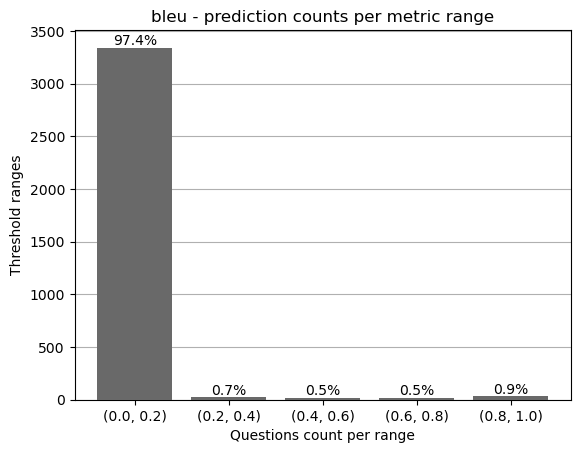

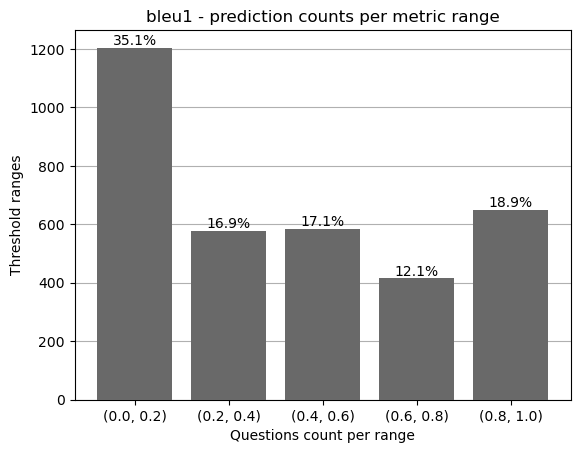

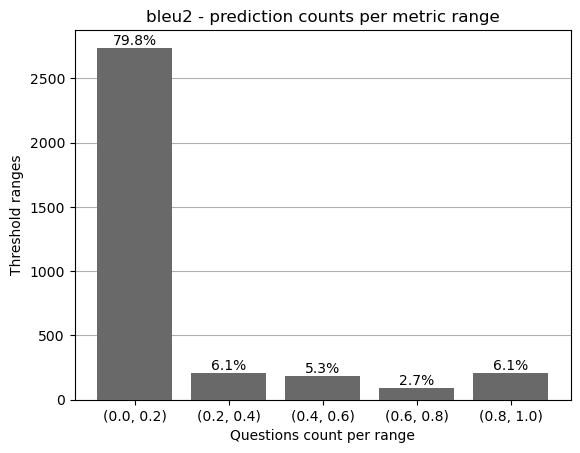

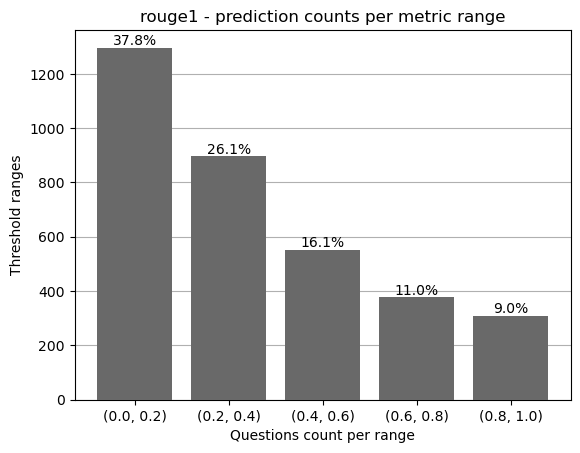

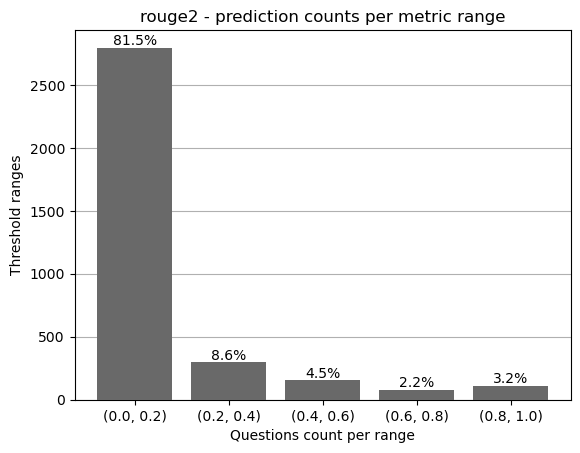

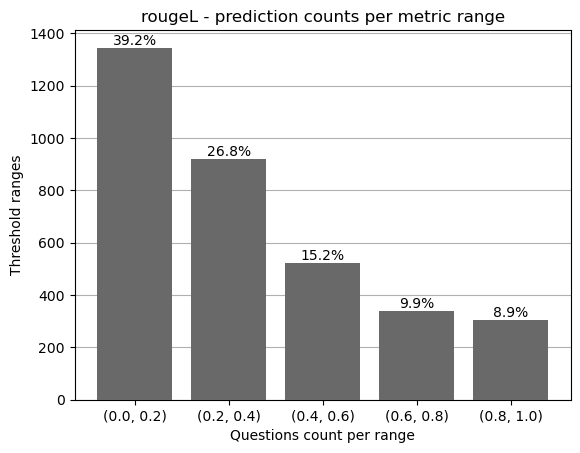

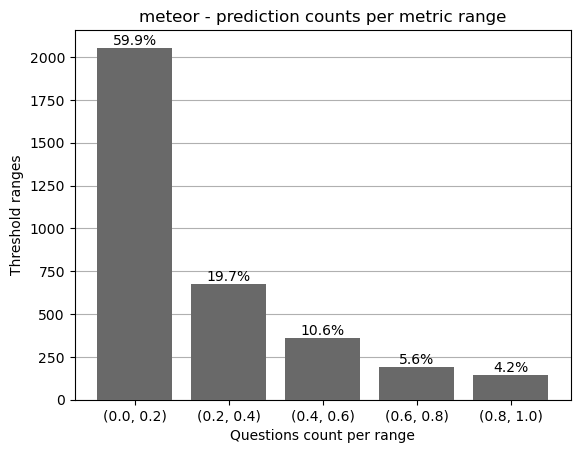

In [6]:
generative_qa_utils.plot_prediction_counts_per_metric_range_diagrams(
    prediction_counts_per_metric = prediction_counts_per_metric_range,
    thresholds=thresholds,
    figure_directory_path=model_evaluation_dir
    )

In [44]:
dataset_dataframe_with_predictions.drop(columns=['index']).to_csv(
    model_evaluation_dir / "test_set_sample_generation.csv", index=True, index_label="index"
)

In [4]:
dataset_dataframe_with_predictions = pd.read_csv(model_evaluation_dir / "test_set_sample_generation.csv")
dataset_dataframe_with_predictions

,index,questions,contexts,labels,predictions,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
0,0,How does the code add a user in the given buck...,def add_bucket_default_owner bucket_name user_...,as an owner,by name,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,1,Does the code add a user in the given buckets ...,def add_bucket_default_owner bucket_name user_...,Yes,Yes,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.500000
2,2,Where does the code add a user as an owner?,def add_bucket_default_owner bucket_name user_...,in the given buckets default object access con...,in a bucket,0.0,0.333333,0.0,0.166667,0.0,0.166667,0.119048
3,3,Does the code create a simple sdist tarball at...,def make_trivial_sdist dist_path setup_py setu...,Yes,Yes,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.500000
4,4,How does the code create a simple sdist tarball?,def make_trivial_sdist dist_path setup_py setu...,at dist_path,using the given setup,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
3425,3425,What does the code add to a virtual service?,def add_server protocol None service_address N...,a real server,a server,0.0,1.000000,0.0,0.800000,0.0,0.800000,0.344828
3426,3426,What does the code get?,def get_codon_alphabet alphabet gap '-' stop '...,alignment alphabet for codon alignment,the codon alphabet,0.0,0.666667,0.0,0.500000,0.0,0.250000,0.208333
3427,3427,What does the code get?,def get_ancestors x collection None if collect...,ancestor random variables of input,the list of possible candidates for the given ...,0.0,0.111111,0.0,0.142857,0.0,0.142857,0.092593
3428,3428,What does the code perform?,def lookupNameservers name timeout None return...,an ns record lookup,a record lookup,0.0,0.666667,0.5,0.571429,0.4,0.571429,0.480769


In [5]:
dataframe_predictions_and_question_types = generative_qa_utils.add_question_types_to_dataset_dataframe(dataset_predictions_dataframe=dataset_dataframe_with_predictions)

In [6]:
only_metric_columns_dataframe = dataframe_predictions_and_question_types[['bleu', 'bleu1', 'bleu2', 'rouge1', 'rouge2', 'rougeL', 'meteor', 'question_type']]
metric_mean_values_dataframe = only_metric_columns_dataframe.groupby(['question_type']).mean()
metric_mean_values_dataframe.insert(
    loc=0,
    column='question_type',
    value=list(only_metric_columns_dataframe.groupby(['question_type']).groups.keys())
)
metric_mean_values_dataframe.to_csv(
    model_evaluation_dir / "metric_mean_values.csv", index=False
)
metric_mean_values_dataframe

,question_type,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
question_type,,,,,,,,
closed,closed,0.000000,0.768212,0.000000,0.768212,0.000000,0.768212,0.384106
for_whats,for_whats,0.000000,0.361413,0.106282,0.271447,0.070055,0.266406,0.172930
hows,hows,0.005353,0.180557,0.049485,0.157808,0.044420,0.157045,0.103392
others,others,0.000000,0.402961,0.148106,0.379782,0.126759,0.379782,0.254854
whats,whats,0.020978,0.439310,0.149048,0.346338,0.120723,0.333177,0.231327
whens,whens,0.028142,0.267260,0.114817,0.239482,0.095912,0.237010,0.181014
wheres,wheres,0.014685,0.395537,0.126138,0.347317,0.100854,0.347317,0.225933


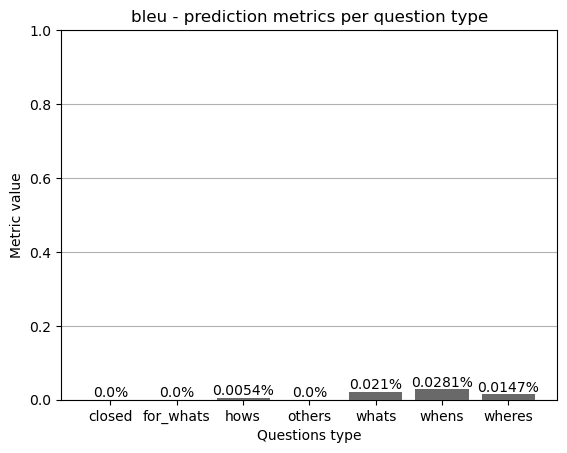

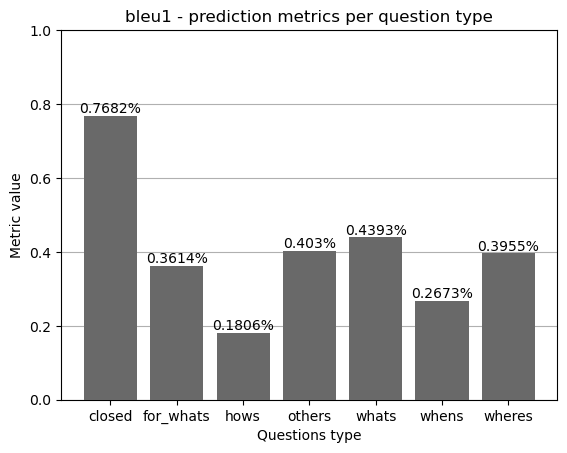

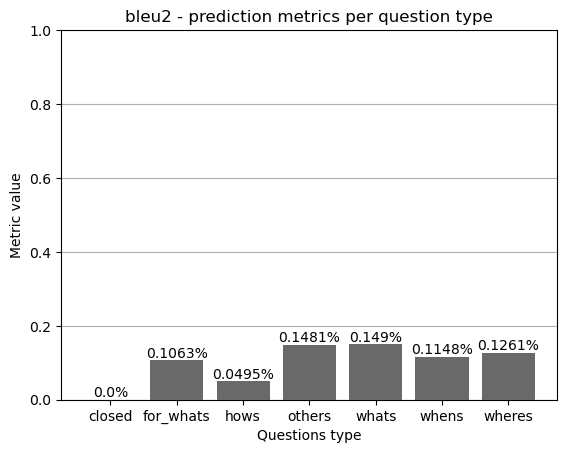

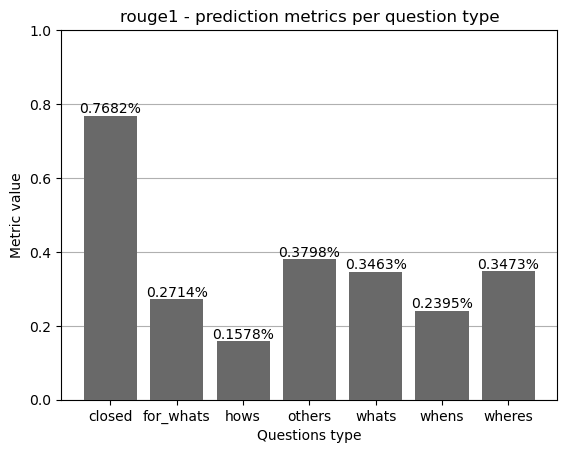

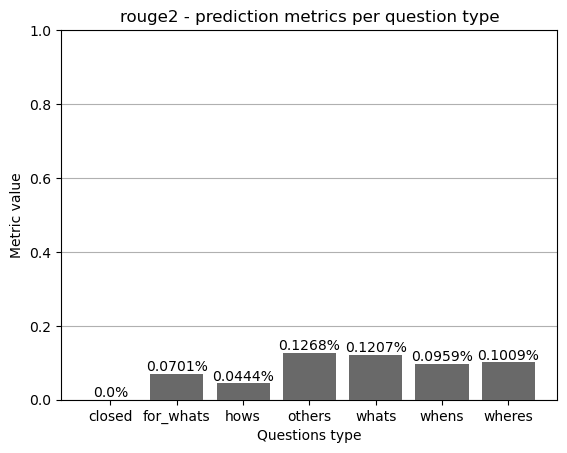

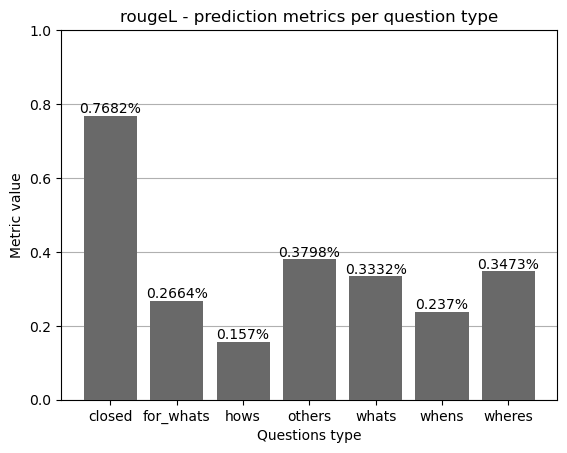

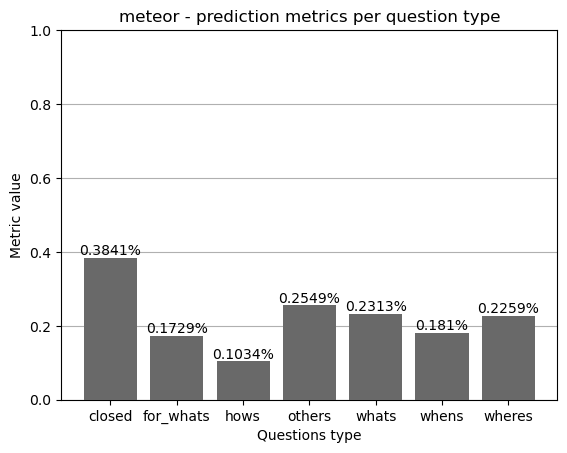

In [7]:
generative_qa_utils.plot_prediction_metrics_per_question_type_diagram(
    metric_mean_values_dataframe=metric_mean_values_dataframe,
    figure_directory_path=model_evaluation_dir / 'figures' / 'metrics-per-type'
)

In [8]:
question_type_metrics_dictionary = generative_qa_utils.count_prediction_numbers_per_metric_range_for_specific_question_type(dataframe_predictions_and_question_types)
generative_qa_utils.save_question_type_metrics_dictionary_to_csv(model_evaluation_dir=model_evaluation_dir, question_type_metrics_dictionary=question_type_metrics_dictionary)
question_type_metrics_dictionary = generative_qa_utils.read_question_type_metrics_dictionary_from_csv(model_evaluation_dir=model_evaluation_dir)
question_type_metrics_dictionary

{'whats':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0  (0.0, 0.2)  2437    797   1955     867    1998     913    1490
 1      1  (0.2, 0.4)    21    446    152     737     229     761     551
 2      2  (0.4, 0.6)    15    466    149     432     123     402     198
 3      3  (0.6, 0.8)    14    333     72     317      67     281     147
 4      4  (0.8, 1.0)    29    474    188     163      99     159     130,
 'wheres':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0  (0.0, 0.2)   180     44    139      55     142      55     104
 1      1  (0.2, 0.4)     0     54     16      60      29      60      46
 2      2  (0.4, 0.6)     0     39     17      39       8      39      10
 3      3  (0.6, 0.8)     1     29      5      18       0      18      17
 4      4  (0.8, 1.0)     2     17      6      11       4      11       6,
 'hows':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0

In [9]:
generative_qa_utils.plot_prediction_counts_per_metric_range_per_question_type_diagram(
    question_type_metrics_dictionary=question_type_metrics_dictionary,
    figure_directory_path=model_evaluation_dir / 'figures' / 'counts-per-metric-range'
)